In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from src.data_reading import parse_galaxy_data
from src.data_treatment_tools import add_radian_columns, new_CoM_procedure 
from src.data_display import    (display_hubble_MW, 
                                display_velocities_distance, 
                                display_velocities_distance_color, 
                                animated_velocities_distance,
                                display_mean_squared_velocity,
                                display_velocities_distance_hubble_regression,
                                display_mean_squared_velocity_consistent
                                )
from IPython.display import clear_output
import matplotlib as mpl
import emcee
import corner
from getdist import MCSamples, plots

In [3]:
galaxy_1_CoM =  "N5128,Cen A"
galaxy_2_CoM =  "N5236, M83"
r=0.76

In [4]:
file_path = 'data/data_clean.txt'
galaxy_df = parse_galaxy_data(file_path)
add_radian_columns(galaxy_df)
# galaxy_df.to_csv("test.csv")

In [5]:
new_CoM_procedure(galaxy_df,galaxy1=galaxy_1_CoM,galaxy2=galaxy_2_CoM,m1_barre=r,grid_incertainty=True)

c:\Users\Adrian\Documents\X\Stage 3A recherche\projet\project_3A\src\data_treatment_tools.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '300.19228135818446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[len(df)] = new_row


CoM_N5128,Cen A_N5236, M83_0.76


In [6]:
row_name="CoM_N5128,Cen A_N5236, M83_0.76"
df=galaxy_df
mask = ~df['Name'].str.startswith('CoM_')
G = 4.3009e-9  # Constante gravitationnelle en (km/s)² Mpc / M☉

# Minor Infall

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2092\760570661.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


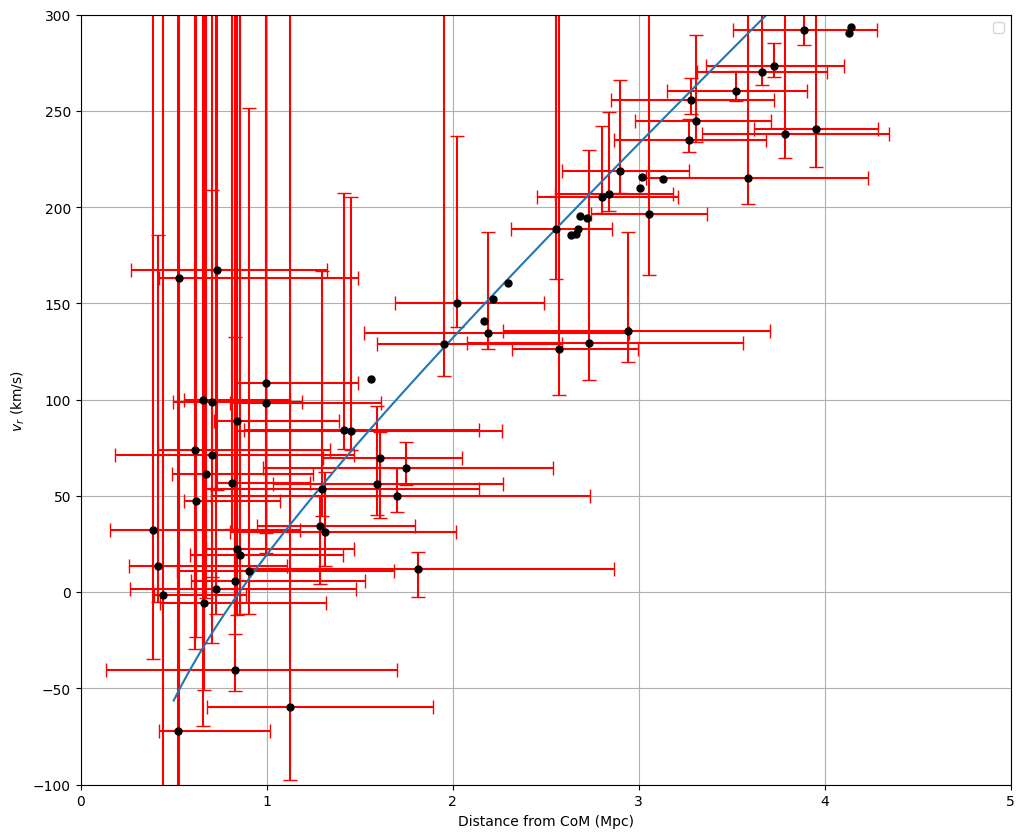

In [7]:
x = pd.to_numeric(df.loc[mask, 'dis_center_'+row_name], errors='coerce').values
y = pd.to_numeric(df.loc[mask,"minor_infall_velocity_"+row_name], errors='coerce').values

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
col_e_x_max = 'e_max_dis_center_' + row_name
col_e_x_min = 'e_min_dis_center_' + row_name
col_e_y_max = 'e_max_major_infall_velocity_bis_'+ row_name
col_e_y_min = 'e_min_minor_infall_velocity_'+ row_name
# col_e_y_max  = 'e_analytic_'+ velocities[i]+"_"+ row_name
# col_e_y_min  = 'e_analytic_'+ velocities[i]+"_"+ row_name
if col_e_y_max in df.columns and col_e_y_min in df.columns and col_e_x_min in df.columns and col_e_x_max in df.columns:
    e_x_min = pd.to_numeric(df.loc[mask, col_e_x_min], errors='coerce').values
    e_x_max = pd.to_numeric(df.loc[mask, col_e_x_max], errors='coerce').values
    e_y_min = pd.to_numeric(df.loc[mask, col_e_y_min], errors='coerce').values
    e_y_max = pd.to_numeric(df.loc[mask, col_e_y_max], errors='coerce').values
    ax.errorbar(x, y, xerr=[e_x_min,e_x_max],yerr=[e_y_min,e_y_max],color="black",markersize=5, fmt='o', capsize=5, ecolor='red')#, label=r"$v_{r,\text{"+velocities[i]+r"}}$ with exact error")

# ax.set_xlabel("Distance from "+row_name+" (Mpc)")
# ax.set_ylabel(r"$v_{r,\text{"+velocities[i]+r"}}$ (km/s)")
ax.set_xlabel("Distance from CoM (Mpc)")
ax.set_ylabel(r"$v_{r}$ (km/s)")
# ax.set_title(r"$V_{r,\text{"+velocities[i]+r"}}$ depending on distance from "+row_name)
ax.legend()
ax.grid(True)
ax.set_xlim(0, 5)  # Limites de l'axe x entre 1 et 5
ax.set_ylim(-100, 300)  # Limites de l'axe y entre -25 et 20



# hubble
def velocity_model(r, H0=70, M=10**12):
    """
    r: distance en mètres
    H0: constante de Hubble en s⁻¹
    M: masse en kg
    Ω_Λ = 0.67 (fixé)
    
    Retourne la vitesse prédite en m/s
    """
    Omega_Lambda = 0.67
    t0 = 0.96 / H0
    
    term1 = H0* (1.1 + 0.31 * Omega_Lambda  ) * r 
    term2 = 1.1 * np.sqrt(G * M / r)
    
    return term1 - term2 

r=np.linspace(0.5,5,100)
v_r=velocity_model(r)
ax.plot(r,v_r)

In [14]:
def analyze_velocity_minor_model(df, mask, row_name,xmin=1,plot=True):
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'minor_infall_velocity_' + row_name,
        'e_min_dis_center_' + row_name,
        'e_max_dis_center_' + row_name,
        'e_min_minor_infall_velocity_' + row_name,
        'e_max_minor_infall_velocity_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['minor_infall_velocity_' + row_name].values

    xerr_low_full = df_clean['e_min_dis_center_' + row_name].values
    xerr_high_full = df_clean['e_max_dis_center_' + row_name].values
    yerr_low_full = df_clean['e_min_minor_infall_velocity_' + row_name].values
    yerr_high_full = df_clean['e_max_minor_infall_velocity_' + row_name].values

    # Apply the (0.5 <= x <= 5) mask uniformly
    mask_fit = (x >= xmin) & (x <= 5)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors for MCMC (missing in original)
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    # -------------------
    # 2. Define the model
    # -------------------
    def velocity_model(r, H0, M):
        Omega_Lambda = 0.67

        # Avoid numerical issues with the square root
        if M <= 0:
            return np.full_like(r, np.nan)  # avoid sqrt of negative mass
        
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Check if the term inside sqrt will be negative
        sqrt_term = G * M / r
        valid_points = sqrt_term > 0
        
        result = np.full_like(r, np.nan)
        if np.any(valid_points):
            result[valid_points] = term1[valid_points] - 1.1 * np.sqrt(sqrt_term[valid_points])
            
        return result

    # -------------------
    # 3. Log-likelihood
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        # Calculate the derivative df/dx numerically
        dr = 1e-5 * r  # small relative step
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        df_dx = (f_plus - f_minus) / (2 * dr)

        # Now compute total error
        return np.sqrt(v_err**2 + (df_dx * r_err)**2)

    def log_likelihood(theta, r, r_err, v, v_err):
        H0, M = theta
        model = velocity_model(r, H0, M)
        if not np.all(np.isfinite(model)):
            return -np.inf
    
        # Total error including propagated uncertainty from r
        v_total_err = total_velocity_error(r, v_err, r_err, H0, M)
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err == 0):
            return -np.inf
    
        return -0.5 * np.sum(((v - model) / v_total_err)**2 + np.log(2 * np.pi * v_total_err**2))

    def log_prior(theta,H0_prior=False,M_prior=False):
        H0, M = theta
        if H0_prior:
            if 1e11 < M < 1e14:
                logp_H0 = -0.5 * ((H0 - 73) / 1.0)**2 - np.log(np.sqrt(2 * np.pi) * 1.0)
                return logp_H0
            return -np.inf
        
        elif M_prior:
            
            if 30 < H0 < 90 and M > 0:
                # Gaussian prior on M: mean=3e12, sigma=1e12
                logp_M = -0.5 * ((M - 3e12) / 1e12)**2 - np.log(np.sqrt(2 * np.pi) * 1e12)
                return logp_M
        else:
            if 30 < H0 < 150 and 0 < M < 1e14:
                return 0.0  # flat prior
            return -np.inf  # log(0)
        return -np.inf

    def log_probability(theta, r, r_err, v, v_err):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, r, r_err, v, v_err)

    # -------------------
    # 4. Run MCMC
    # -------------------
    ndim = 2
    nwalkers = 32
    p0 = np.array([70, 1e12]) + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler_min = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                     args=(x, xerr_sym, y, yerr_sym))
    sampler_min.run_mcmc(p0, 5000, progress=True)

    # Get the flat samples (renamed from the original)
    samples_min = sampler_min.get_chain(discard=1000, thin=15, flat=True)

    # -------------------
    # 5. Use GetDist for posterior plots
    # -------------------
    if plot:
        names = ['H0', 'M']
        labels = [r'H_0', r'M \,[kg]']  # LaTeX labels

        # Create MCSamples object from your MCMC samples
        gdsamples_min = MCSamples(samples=samples_min, names=names, labels=labels)

        # Create the triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_min, filled=True)
        plt.show()

        # -------------------
        # 6. Plot best-fit model
        # -------------------
        H0_mcmc, M_mcmc = np.median(samples_min, axis=0)


        H0_lower, M_lower = np.percentile(samples_min, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_min, 84, axis=0)

        # Compute uncertainties
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)

        # Fine grid
        r_plot = np.linspace(xmin, 5, 200)
        v_median = velocity_model(r_plot, H0_mcmc, M_mcmc)

        # Sample 100 posterior draws to make uncertainty band
        v_samples_min = np.array([velocity_model(r_plot, h0, m) for h0, m in samples_min[np.random.choice(len(samples_min), 1000, replace=False)]])

        v_lower = np.percentile(v_samples_min, 0.15, axis=0)
        v_upper = np.percentile(v_samples_min, 99.15, axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                    fmt='o', color='black', ecolor='red', capsize=5, label='Data')

        ax.plot(r_plot, v_median, 'r-', color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.3, label=rf"$3\sigma$ credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v{r}$ (km/s)")
        ax.grid(True)
        ax.set_xlim(0, 5)
        ax.set_ylim(-100, 300)
        ax.legend()
        plt.plot()
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
    else:
        H0_mcmc, M_mcmc = np.median(samples_min, axis=0)
        H0_lower, M_lower = np.percentile(samples_min, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_min, 84, axis=0)
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:17<00:00, 290.23it/s]


Removed no burn in


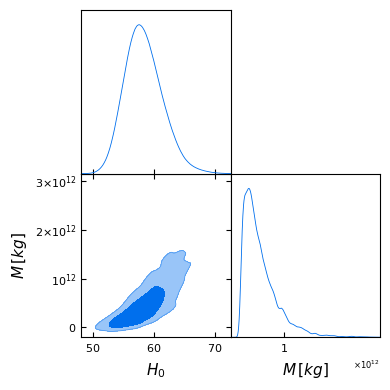

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2092\3587218981.py:166: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(r_plot, v_median, 'r-', color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))


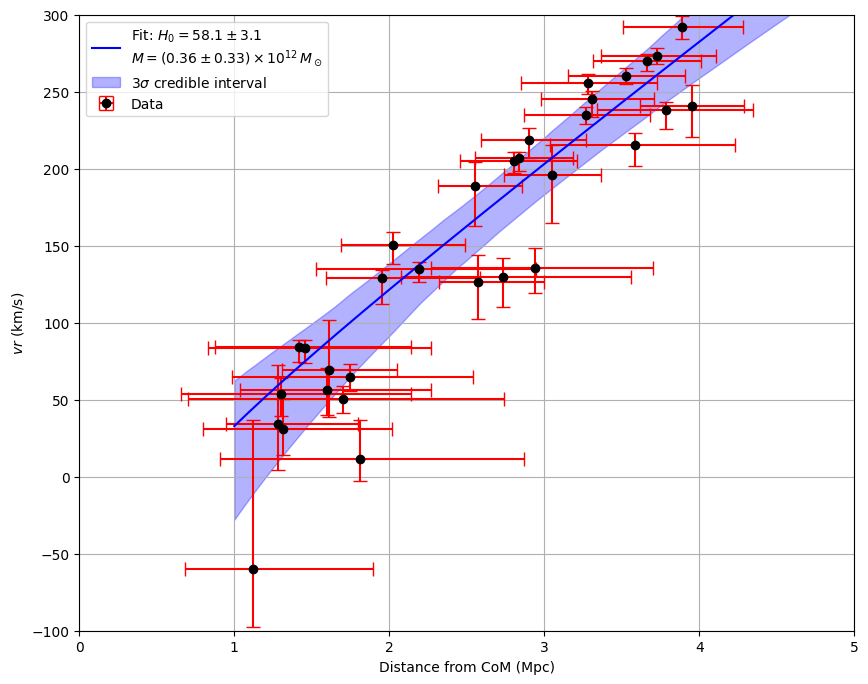

In [16]:
H0,H0_sigma, M,M_sigma, samples_min  = analyze_velocity_minor_model(df, mask, row_name, xmin=1)

100%|██████████| 5000/5000 [00:15<00:00, 315.20it/s]


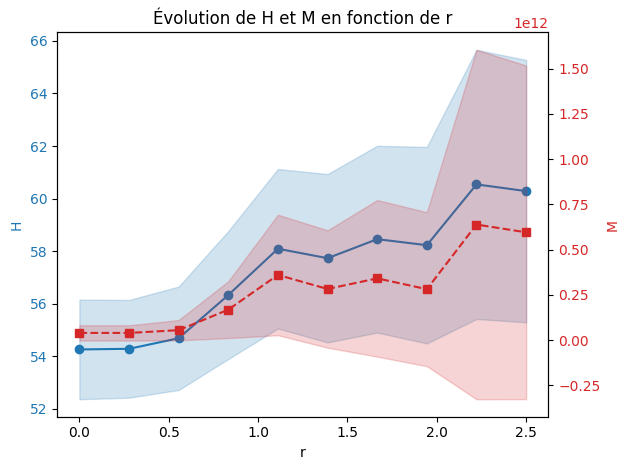

In [17]:
# Vecteur r (de 0 à 4, 10 points)
r_plot = np.linspace(0, 2.5, 10)

H_values = []
H_sigmas = []
M_values = []
M_sigmas = []
# Remplissage des valeurs
for k in r_plot:
    H0, H0_sigma, M , M_sigma, _ = analyze_velocity_minor_model(df, mask, row_name, xmin=k,plot= False)
    H_values.append(H0)
    H_sigmas.append(H0_sigma)
    M_values.append(M)
    M_sigmas.append(M_sigma)

# Création de la figure
fig, ax1 = plt.subplots()

# Axe primaire pour H
ax1.set_xlabel("r")
ax1.set_ylabel("H", color="tab:blue")
ax1.plot(r_plot, H_values, marker='o', color="tab:blue", label="H")
ax1.fill_between(r_plot,
                 np.array(H_values) - np.array(H_sigmas),
                 np.array(H_values) + np.array(H_sigmas),
                 color="tab:blue", alpha=0.2, label="H uncertainty")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Axe secondaire pour M
ax2 = ax1.twinx()
ax2.set_ylabel("M", color="tab:red")
ax2.plot(r_plot, M_values, marker='s', linestyle='--', color="tab:red", label="M")
ax2.fill_between(r_plot,
                 np.array(M_values) - np.array(M_sigmas),
                 np.array(M_values) + np.array(M_sigmas),
                 color="tab:red", alpha=0.2, label="M uncertainty")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Titre et mise en page
plt.title("Évolution de H et M en fonction de r")
fig.tight_layout()

# Affichage du graphique
plt.show()


# Major infall

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2024\39162567.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


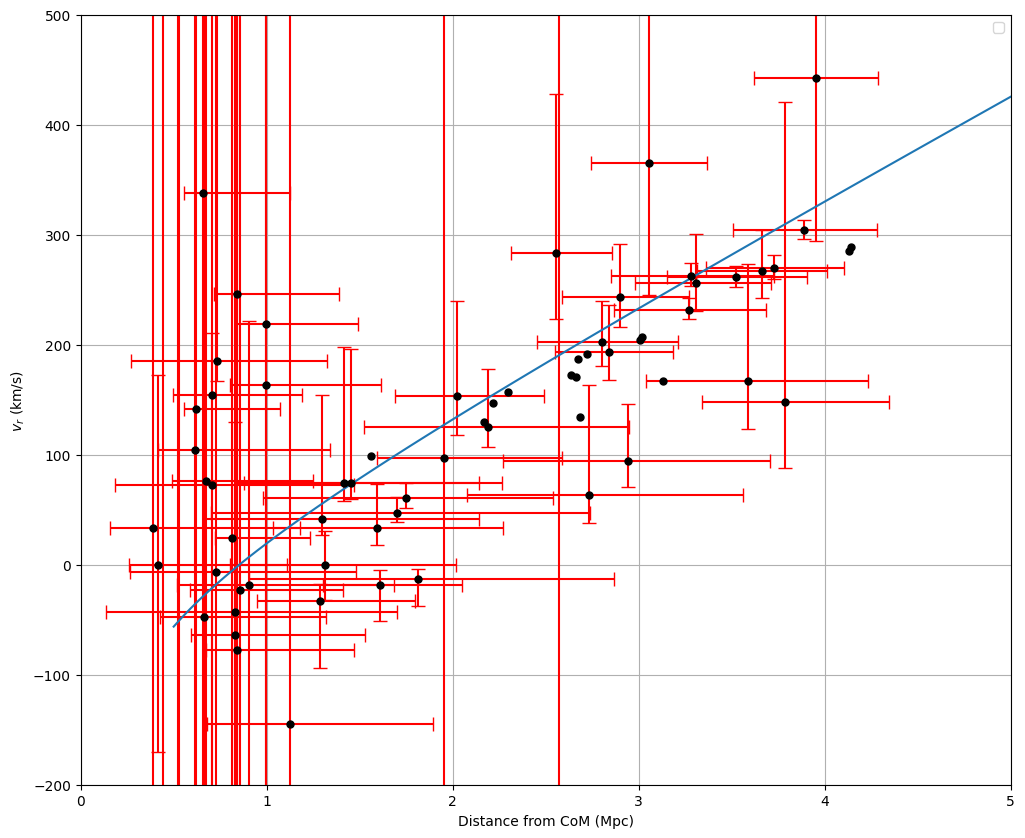

In [ ]:
x = pd.to_numeric(df.loc[mask, 'dis_center_'+row_name], errors='coerce').values
y = pd.to_numeric(df.loc[mask,"major_infall_velocity_bis_"+row_name], errors='coerce').values

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
col_e_x_max = 'e_max_dis_center_' + row_name
col_e_x_min = 'e_min_dis_center_' + row_name
col_e_y_max = 'e_max_major_infall_velocity_bis_'+ row_name
col_e_y_min = 'e_min_major_infall_velocity_bis_'+ row_name
# col_e_y_max  = 'e_analytic_'+ velocities[i]+"_"+ row_name
# col_e_y_min  = 'e_analytic_'+ velocities[i]+"_"+ row_name
if col_e_y_max in df.columns and col_e_y_min in df.columns and col_e_x_min in df.columns and col_e_x_max in df.columns:
    e_x_min = pd.to_numeric(df.loc[mask, col_e_x_min], errors='coerce').values
    e_x_max = pd.to_numeric(df.loc[mask, col_e_x_max], errors='coerce').values
    e_y_min = pd.to_numeric(df.loc[mask, col_e_y_min], errors='coerce').values
    e_y_max = pd.to_numeric(df.loc[mask, col_e_y_max], errors='coerce').values
    ax.errorbar(x, y, xerr=[e_x_min,e_x_max],yerr=[e_y_min,e_y_max],color="black",markersize=5, fmt='o', capsize=5, ecolor='red')#, label=r"$v_{r,\text{"+velocities[i]+r"}}$ with exact error")

# ax.set_xlabel("Distance from "+row_name+" (Mpc)")
# ax.set_ylabel(r"$v_{r,\text{"+velocities[i]+r"}}$ (km/s)")
ax.set_xlabel("Distance from CoM (Mpc)")
ax.set_ylabel(r"$v_{r}$ (km/s)")
# ax.set_title(r"$V_{r,\text{"+velocities[i]+r"}}$ depending on distance from "+row_name)
ax.legend()
ax.grid(True)
ax.set_xlim(0, 5)  # Limites de l'axe x entre 1 et 5
ax.set_ylim(-200, 500)  # Limites de l'axe y entre -25 et 20



# hubble
def velocity_model(r, H0=70, M=10**12):
    """
    r: distance en mètres
    H0: constante de Hubble en s⁻¹
    M: masse en kg
    Ω_Λ = 0.67 (fixé)
    
    Retourne la vitesse prédite en m/s
    """
    Omega_Lambda = 0.67
    t0 = 0.96 / H0
    
    term1 = H0* (1.1 + 0.31 * Omega_Lambda  ) * r 
    term2 = 1.1 * np.sqrt(G * M / r)
    
    return term1 - term2 

r=np.linspace(0.5,5,100)
v_r=velocity_model(r)
ax.plot(r,v_r)

In [23]:
def analyze_velocity_major_model(df, mask, row_name,xmin=1,plot=True):
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'major_infall_velocity_bis_' + row_name,
        'e_min_dis_center_' + row_name,
        'e_max_dis_center_' + row_name,
        'e_min_major_infall_velocity_bis_' + row_name,
        'e_max_major_infall_velocity_bis_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['major_infall_velocity_bis_' + row_name].values

    xerr_low_full = df_clean['e_min_dis_center_' + row_name].values
    xerr_high_full = df_clean['e_max_dis_center_' + row_name].values
    yerr_low_full = df_clean['e_min_major_infall_velocity_bis_' + row_name].values
    yerr_high_full = df_clean['e_max_major_infall_velocity_bis_' + row_name].values

    # Apply the (0.5 <= x <= 5) mask uniformly
    mask_fit = (x >= xmin) & (x <= 5)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors for MCMC (missing in original)
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    # -------------------
    # 2. Define the model
    # -------------------
    def velocity_model(r, H0, M):
        Omega_Lambda = 0.67

        # Avoid numerical issues with the square root
        if M <= 0:
            return np.full_like(r, np.nan)  # avoid sqrt of negative mass
        
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Check if the term inside sqrt will be negative
        sqrt_term = G * M / r
        valid_points = sqrt_term > 0
        
        result = np.full_like(r, np.nan)
        if np.any(valid_points):
            result[valid_points] = term1[valid_points] - 1.1 * np.sqrt(sqrt_term[valid_points])
            
        return result

    # -------------------
    # 3. Log-likelihood
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        # Calculate the derivative df/dx numerically
        dr = 1e-5 * r  # small relative step
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        df_dx = (f_plus - f_minus) / (2 * dr)

        # Now compute total error
        return np.sqrt(v_err**2 + (df_dx * r_err)**2)

    def log_likelihood(theta, r, r_err, v, v_err):
        H0, M = theta
        model = velocity_model(r, H0, M)
        if not np.all(np.isfinite(model)):
            return -np.inf
    
        # Total error including propagated uncertainty from r
        v_total_err = total_velocity_error(r, v_err, r_err, H0, M)
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err == 0):
            return -np.inf
    
        return -0.5 * np.sum(((v - model) / v_total_err)**2 + np.log(2 * np.pi * v_total_err**2))

    def log_prior(theta,H0_prior=False,M_prior=False):
        H0, M = theta
        if H0_prior:
            if 1e11 < M < 1e14:
                logp_H0 = -0.5 * ((H0 - 73) / 1.0)**2 - np.log(np.sqrt(2 * np.pi) * 1.0)
                return logp_H0
            return -np.inf
        
        elif M_prior:
            
            if 30 < H0 < 90 and M > 0:
                # Gaussian prior on M: mean=3e12, sigma=1e12
                logp_M = -0.5 * ((M - 3e12) / 1e12)**2 - np.log(np.sqrt(2 * np.pi) * 1e12)
                return logp_M
        else:
            if 30 < H0 < 150 and 0 < M < 1e14:
                return 0.0  # flat prior
            return -np.inf  # log(0)
        return -np.inf

    def log_probability(theta, r, r_err, v, v_err):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, r, r_err, v, v_err)

    # -------------------
    # 4. Run MCMC
    # -------------------
    ndim = 2
    nwalkers = 32
    p0 = np.array([70, 1e12]) + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler_maj = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                     args=(x, xerr_sym, y, yerr_sym))
    sampler_maj.run_mcmc(p0, 5000, progress=True)

    # Get the flat samples (renamed from the original)
    samples_maj = sampler_maj.get_chain(discard=1000, thin=15, flat=True)

    # -------------------
    # 5. Use GetDist for posterior plots
    # -------------------
    if plot:
        names = ['H0', 'M']
        labels = [r'H_0', r'M \,[kg]']  # LaTeX labels

        # Create MCSamples object from your MCMC samples
        gdsamples_maj = MCSamples(samples=samples_maj, names=names, labels=labels)

        # Create the triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_maj, filled=True)
        plt.show()

        # -------------------
        # 6. Plot best-fit model
        # -------------------
        H0_mcmc, M_mcmc = np.median(samples_maj, axis=0)


        H0_lower, M_lower = np.percentile(samples_maj, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_maj, 84, axis=0)

        # Compute uncertainties
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)

        # Fine grid
        r_plot = np.linspace(1, 5, 200)
        v_median = velocity_model(r_plot, H0_mcmc, M_mcmc)

        # Sample 100 posterior draws to make uncertainty band
        v_samples_maj = np.array([velocity_model(r_plot, h0, m) for h0, m in samples_maj[np.random.choice(len(samples_maj), 1000, replace=False)]])

        v_lower = np.percentile(v_samples_maj, 0.15, axis=0)
        v_upper = np.percentile(v_samples_maj, 99.85, axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                    fmt='o', color='black', ecolor='red', capsize=5, label='Data')
        ax.plot(r_plot,v_median,color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))    
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.3, label=rf"$3\sigma$ credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v{r}$ (km/s)")
        ax.grid(True)
        ax.set_xlim(0, 5)
        ax.set_ylim(-100, 300)
        ax.legend()

        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
    else:
        H0_mcmc, M_mcmc = np.median(samples_maj, axis=0)
        H0_lower, M_lower = np.percentile(samples_maj, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_maj, 84, axis=0)
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
        

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:18<00:00, 277.23it/s]


Removed no burn in


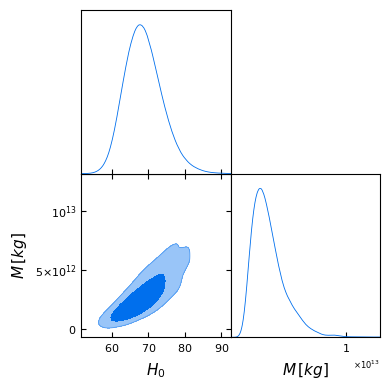

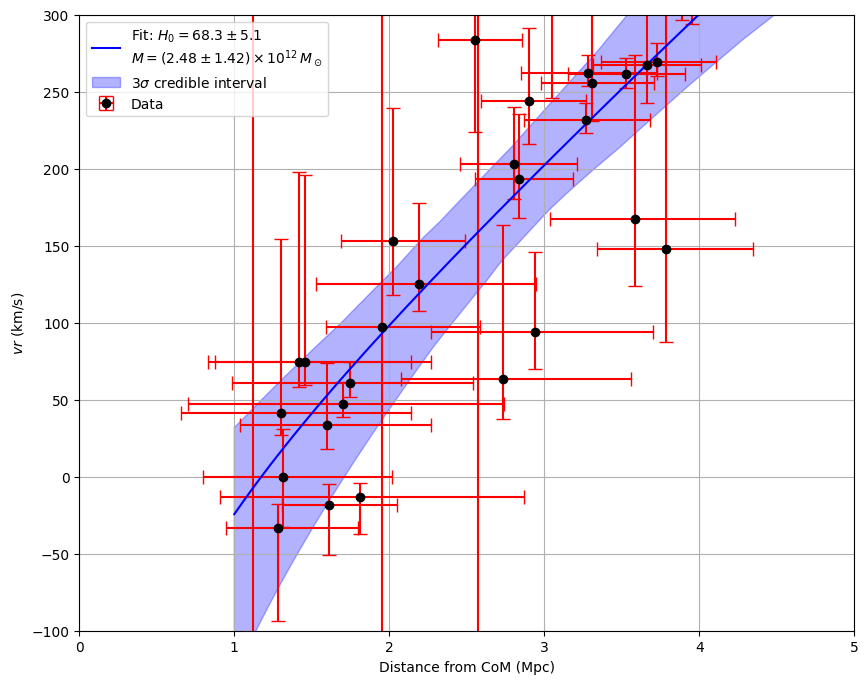

In [24]:
H0, H0_sigma, M , M_sigma, samples_maj = analyze_velocity_major_model(galaxy_df, mask, row_name)

100%|██████████| 5000/5000 [00:15<00:00, 316.34it/s]


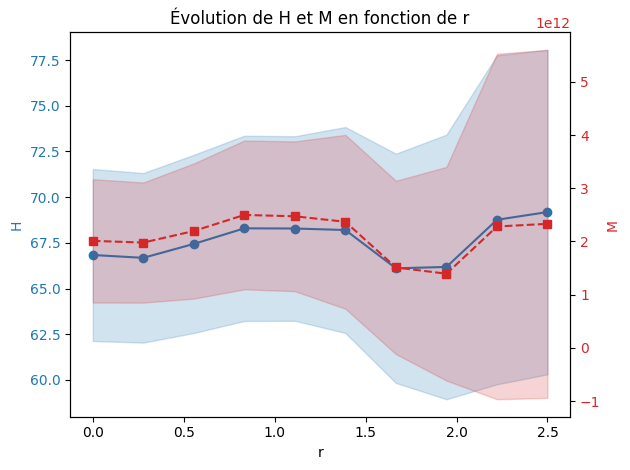

In [25]:
# Vecteur r (de 0 à 4, 10 points)
r_plot = np.linspace(0, 2.5, 10)

H_values = []
H_sigmas = []
M_values = []
M_sigmas = []
# Remplissage des valeurs
for k in r_plot:
    H0, H0_sigma, M , M_sigma, _ = analyze_velocity_major_model(df, mask, row_name, xmin=k,plot= False)
    H_values.append(H0)
    H_sigmas.append(H0_sigma)
    M_values.append(M)
    M_sigmas.append(M_sigma)

# Création de la figure
fig, ax1 = plt.subplots()

# Axe primaire pour H
ax1.set_xlabel("r")
ax1.set_ylabel("H", color="tab:blue")
ax1.plot(r_plot, H_values, marker='o', color="tab:blue", label="H")
ax1.fill_between(r_plot,
                 np.array(H_values) - np.array(H_sigmas),
                 np.array(H_values) + np.array(H_sigmas),
                 color="tab:blue", alpha=0.2, label="H uncertainty")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Axe secondaire pour M
ax2 = ax1.twinx()
ax2.set_ylabel("M", color="tab:red")
ax2.plot(r_plot, M_values, marker='s', linestyle='--', color="tab:red", label="M")
ax2.fill_between(r_plot,
                 np.array(M_values) - np.array(M_sigmas),
                 np.array(M_values) + np.array(M_sigmas),
                 color="tab:red", alpha=0.2, label="M uncertainty")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Titre et mise en page
plt.title("Évolution de H et M en fonction de r")
fig.tight_layout()

# Affichage du graphique
plt.show()

Removed no burn in
Removed no burn in


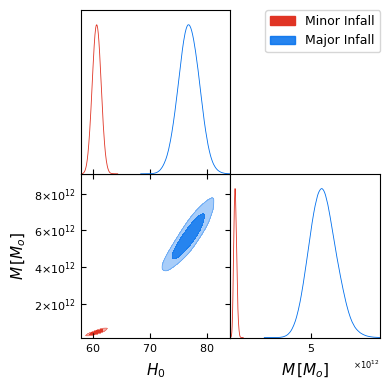

In [ ]:
names = ['H0', 'M']
labels = [r'H_0', r'M \,[M_o]']  # LaTeX labels

# Create MCSamples object from your MCMC samples
gdsamples_min = MCSamples(samples=samples_min, names=names, labels=labels)
gdsamples_maj = MCSamples(samples=samples_maj, names=names, labels=labels)

# Create the triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([gdsamples_min, gdsamples_maj], filled=True, 
                legend_labels=['Minor Infall', 'Major Infall'])

plt.show()